## Библиотеки

In [172]:
import pandas as pd # Работа с таблицами
import numpy as np # Математика над таблицами
import pingouin as pg # Для статистических методов
import requests # Для загрузки данных
from urllib.parse import urlencode # Для загрузки данных
import seaborn as sns # Для визуализации
import matplotlib.pyplot as plt # Для файнтюнинга визуализации
from random import sample # Для симмуляции
from random import seed # Для воспроизводимости
%matplotlib inline

## Посмотрим данные

### groups.csv
файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [173]:
# Объявим нужные функции

#Функция для получения датафрейма по ссылке на яндекс диск
def get_df_rom_ya_disk(public_key, sep = ','):
    # Используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
 
    # Получаем url 
    final_url = base_url + urlencode(dict(public_key=public_key)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
 
    # Загружаем файл в df 
    download_response = requests.get(download_url) 
    return pd.read_csv(download_url, sep = sep) 

In [174]:
# Выгрузим
groups = get_df_rom_ya_disk('https://disk.yandex.ru/d/UhyYx41rTt3clQ', ';')
groups = groups.rename(columns = {'id':'user_id', 'grp':'group'})
print(groups.isna().sum()) # Пропусков нет
print(groups.nunique()) # Без дублей
groups

user_id    0
group      0
dtype: int64
user_id    74484
group          2
dtype: int64


,user_id,group
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


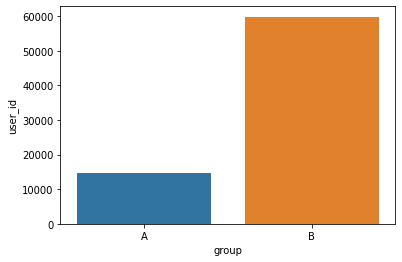

In [175]:
# Посмотрим распредление
groups_count = groups.groupby('group', as_index = False).agg('count')
sns.barplot(data = groups_count, x ="group", y = "user_id")

# Мы явно видим ассиметрию в группах, это надо будет потом учесть

### groups_add.csv
дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

In [176]:
# Выгрузим
groups_add = get_df_rom_ya_disk('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', ',')
groups_add = groups_add.rename(columns = {'id':'user_id', 'grp':'group'})
print(groups_add.isna().sum()) # Пропусков нет
print(groups_add.nunique()) # Без дублей
groups_add

user_id    0
group      0
dtype: int64
user_id    92
group       2
dtype: int64


,user_id,group
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


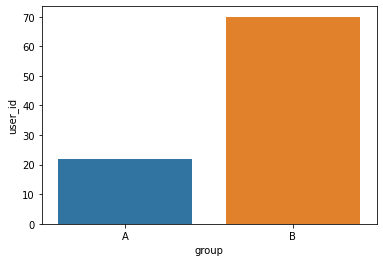

In [177]:
# Посмотрим распредление
groups_add_count = groups_add.groupby('group', as_index = False).agg('count')
sns.barplot(data = groups_add_count, x ="group", y = "user_id")

# Мы явно видим ассиметрию в группах, это надо будет потом учесть

In [178]:
# В обоих выборка явный дисбаланс по распределению
# Также данные собраны в разное время
# Так как мы не знаем, почему вторая партия отдельно была прислана, то стоит воздержаться от соединения датасетов
# Я решаю опираться на начальную выборку
# Вторую выборку рассматривать отдельно нет возможности из-за малых размеров

### active_studs.csv
файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

In [179]:
active_studs = get_df_rom_ya_disk('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ', ',')
active_studs = active_studs.rename(columns = {'student_id':'user_id'})
print(active_studs.isna().sum()) # Пропусков нет
print(active_studs.nunique()) # Без дублей
active_studs

user_id    0
dtype: int64
user_id    8341
dtype: int64


,user_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


### checks.csv
файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [180]:
checks = get_df_rom_ya_disk('https://disk.yandex.ru/d/pH1q-VqcxXjsVA', ';')
checks = checks.rename(columns = {'student_id':'user_id'})
print(checks.isna().sum()) # Пропусков нет
print(checks.nunique()) # Без дублей
checks

user_id    0
rev        0
dtype: int64
user_id    541
rev         39
dtype: int64


,user_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


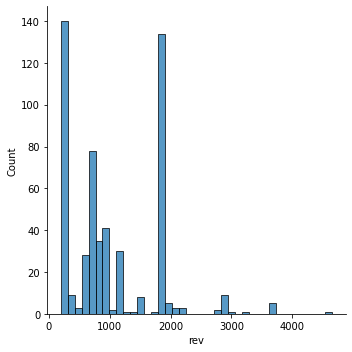

In [181]:
sns.displot(data = checks, x = "rev", bins = 39)
# Не похоже на какое-то конкретное распределение, но как-будто две явные моды, 
# это в целом согласуется с идеей о наличии двух групп

## Анализ метрик
Так как меняется только механизм оплаты, 
то мы опустим рассмотрение доли активных пользователей от всего пользователей пользователей группе

Я предлагалаю рассмотреть 3 следующие метрики:
    1. Конверсия из активности в покупку по группам (Хи-квадрат)
    2. Средний чек по группам (t-test)
    3. Сумма, если бы количество пользователей было одинаковым (bootstrap)

### Конверсия из активности в покупку по группам
Этой метрикой мы посмотрим то, есть ли разница в том, насколько охотно люди будут покупать (в зависимости от группы)
Смотрим на то, не просела ли метрика, а может наоборот поднялась

Выберем альфу 0.01

И мощность 0.99

Если результат получится незначимым, то посчитаем MDE

In [182]:
# Подготовим датафрейм
active_studs_gr = active_studs.merge(groups, how = 'inner', on = 'user_id')
res = active_studs_gr.merge(checks, how = 'left', on = 'user_id')
res.rev = res.rev.isna().apply(lambda x: not x).astype(int)
res = res.rename(columns = {'rev':'paid'})
res

,user_id,group,paid
0,581585,A,0
1,3276743,B,0
2,4238589,A,0
3,4475369,B,0
4,5481015,B,0
...,...,...,...
8323,1794344,B,0
8324,296883,B,0
8325,3598448,B,0
8326,3610547,B,1


In [183]:
# Посчитаем тест
expected, observed, stats = pg.chi2_independence(data = res, x = 'group', y = 'paid', correction = True) # Применяем корректировку
# так как количество степеней свободы = 1

In [184]:
# Ожидаемое распредление
expected

paid,0,1
group,,
A,1462.931676,72.068324
B,6474.068324,318.931676


In [185]:
# Наблюдаемое распредление
observed # тут мы также видим выполнение допущения об отсутствии очень маленьких групп (<5)
# Допущение о независимости мы принимае по умолчанию

paid,0,1
group,,
A,1457.5,77.5
B,6479.5,313.5


In [186]:
# Статистики
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.526607,1.0,0.468037,0.007952,0.112168
1,cressie-read,0.666667,0.523446,1.0,0.469375,0.007928,0.111786
2,log-likelihood,0.000000,0.517247,1.0,0.472019,0.007881,0.111037
3,freeman-tukey,-0.500000,0.512702,1.0,0.473971,0.007846,0.110488
4,mod-log-likelihood,-1.000000,0.508246,1.0,0.475899,0.007812,0.109950
5,neyman,-2.000000,0.499590,1.0,0.479680,0.007745,0.108905


In [187]:
# Минимальный заметный эффект
pg.power_chi2(dof=1, n=8328, power=0.99, alpha=0.01) # Эффект chohen's d

0.05371785288525443

Разница между группами статистически не значима, то есть внедрение на выборке другого способа оплаты не повлияло на конверсию из активности в покупку. MDE очень низкий, то есть мы бы заметили даже маааленький эффект

### Cредний чек по группам
Этой метрикой мы посмотрим меняется ли средний чек в группах

Выберем альфу 0.05

И мощность 0.90

Если результат получится незначимым, то посчитаем MDE

In [188]:
checks_with_group = checks.merge(groups, how = 'inner', on = 'user_id')
checks_with_group

,user_id,rev,group
0,1627,990.0,A
1,3185,690.0,B
2,25973,690.0,B
3,26280,690.0,B
4,100300,990.0,B
...,...,...,...
535,5609523,1900.0,B
536,5645737,1900.0,B
537,5651566,1900.0,B
538,5662322,1900.0,B


In [189]:
# Проверим равенство дисперсий
pg.homoscedasticity(data = checks_with_group, dv = "rev", group = "group", method = "bartlett")
# Дисперсии равные

,T,pval,equal_var
bartlett,1.601113,0.205746,True


In [190]:
# Сам t-test, хоть дисперсии и равные, но всё-таки используем поправку Велча, так как группы разные по размеру
pg.ttest(
         x = checks_with_group[checks_with_group['group'] == "A"]["rev"], 
         y = checks_with_group[checks_with_group['group'] == "B"]["rev"],
         correction = True
)
# Различие получилось значимым, на выбранном уровне альфа

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.845427,152.158777,two-sided,0.005047,"[-417.29, -75.28]",0.325388,5.696,0.852826


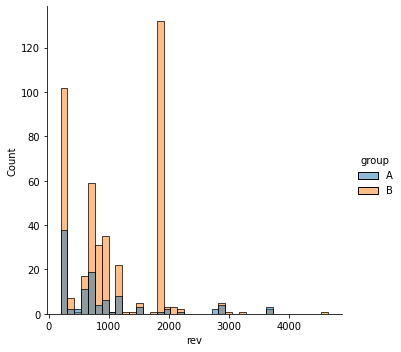

In [191]:
# График распределения
sns.displot(data = checks_with_group, x = "rev", hue = "group", bins = 39)

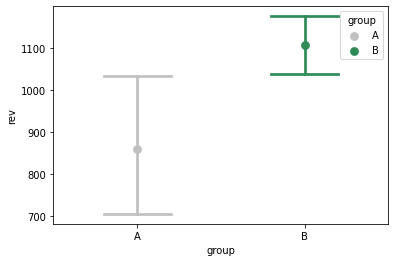

In [192]:
sns.pointplot(data = checks_with_group, linestyles = "none", 
              x = "group", 
              hue = "group",
              y = "rev", 
              errorbar = "ci", 
              capsize=.4, 
              palette=["#C0C0C0", "#2E8B57"], 
              marker="D")

Введение нового механизма оплаты дало на выборке увеличение суммы среднего чека

### Сумма, если бы количество пользователей было одинаковым
Это в целом целевая метрика, можем её смоделировать

Сделаем это так:
1. Возьмём активных пользователей
2. Присоединим в к ним группы
3. К прошлому шагу присоединим чеки, заменяя пропуски нулями
4. Поделим на две выборки (A и B группы)
5. Будем из каждой группы брать по 1000 наблюдений с возвратом и считать сумму
6. Повторим 1000 раз для каждой группы
7. Соберём один датасет
8. Проведём t-test

In [193]:
# Шаги 1-3
rev_0 = active_studs_gr.merge(checks, how = 'left', on = 'user_id').fillna(0)
rev_0

,user_id,group,rev
0,581585,A,0.0
1,3276743,B,0.0
2,4238589,A,0.0
3,4475369,B,0.0
4,5481015,B,0.0
...,...,...,...
8323,1794344,B,0.0
8324,296883,B,0.0
8325,3598448,B,0.0
8326,3610547,B,290.0


In [194]:
# Шаг 4.1
rev_0_a = rev_0.query('group == "A"')
rev_0_a

,user_id,group,rev
0,581585,A,0.0
2,4238589,A,0.0
6,1394612,A,0.0
20,5194768,A,0.0
21,3658923,A,0.0
...,...,...,...
8304,3208984,A,0.0
8307,2900558,A,0.0
8313,1161774,A,0.0
8317,5006972,A,0.0


In [195]:
# Шаг 4.2
rev_0_b = rev_0.query('group == "B"')
rev_0_b

,user_id,group,rev
1,3276743,B,0.0
3,4475369,B,0.0
4,5481015,B,0.0
5,1353433,B,0.0
7,1170611,B,0.0
...,...,...,...
8323,1794344,B,0.0
8324,296883,B,0.0
8325,3598448,B,0.0
8326,3610547,B,290.0


In [201]:
# Шаг (5-6).1
seed(10)
sm_a = []
for i in range(0, 1000):
    sm_a.append(sum(sample(list(rev_0_a['rev']), 1000)))
sm_a
boot_a = pd.DataFrame(sm_a, columns = ['total_rev'])
boot_a['group'] = 'A'
boot_a

,total_rev,group
0,52412.0,A
1,36803.0,A
2,29323.0,A
3,50133.0,A
4,47282.0,A
...,...,...
995,43953.0,A
996,45293.0,A
997,48164.0,A
998,43994.0,A


In [202]:
# Шаг (5-6).2
seed(10)
sm_b = []
for i in range(0, 1000):
    sm_b.append(sum(sample(list(rev_0_b['rev']), 1000)))
sm_b
boot_b = pd.DataFrame(sm_b, columns = ['total_rev'])
boot_b['group'] = 'B'
boot_b

,total_rev,group
0,46431.0008,B
1,69999.0006,B
2,71428.0005,B
3,55539.0005,B
4,59493.0003,B
...,...,...
995,61979.0008,B
996,65750.0007,B
997,48619.0001,B
998,48401.0006,B


In [203]:
# Шаг 7
boot_total = pd.concat([boot_a, boot_b])
boot_total

,total_rev,group
0,52412.0000,A
1,36803.0000,A
2,29323.0000,A
3,50133.0000,A
4,47282.0000,A
...,...,...
995,61979.0008,B
996,65750.0007,B
997,48619.0001,B
998,48401.0006,B


In [204]:
# Шаг 8.1
# Проверим равенство дисперсий
pg.homoscedasticity(data = boot_total, dv = "total_rev", group = "group", method = "bartlett")
# Дисперсии разные, используем поправку

,T,pval,equal_var
bartlett,260.371535,1.424068e-58,False


In [205]:
# Шаг 8.2
# Сам t-test
pg.ttest(
         x = boot_a["total_rev"], 
         y = boot_b["total_rev"],
         correction = True
)
# Различие получилось значимым, на выбранном уровне альфа. Сила эффекта высокая

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-32.436032,1625.002983,two-sided,2.188522e-178,"[-11512.87, -10199.88]",1.450583,4.105e+181,1.0


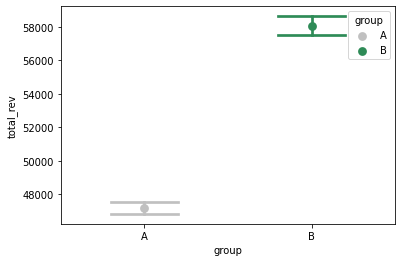

In [206]:
# Построим среднее и доверительные интервалы
sns.pointplot(data = boot_total, linestyles = "none", 
              x = "group", 
              hue = "group",
              y = "total_rev", 
              errorbar = "ci", 
              capsize=.4, 
              palette=["#C0C0C0", "#2E8B57"], 
              marker="D")

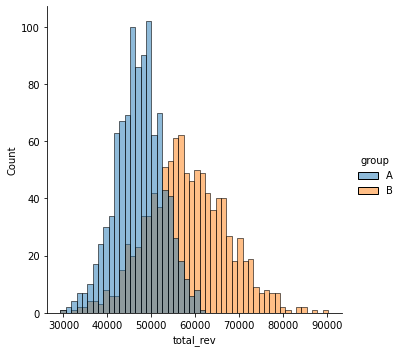

In [207]:
# Построим распределения
sns.displot(data = boot_total, x = "total_rev", hue = "group", bins = 50)

Мы симмулировали 1000 ситуаций, где количество человек в каждой группе было бы равно и посчитали суммы для кажой такой ситуации, затем построили распредления

Итого, в группе B суммарная выручка с высокой долей вероятности больше

## Итог по A/B

Мы столкнулись с ситуацией двйоной поставки данных, от второй - малой порции было решено отказаться: её невозможно анализировать отдельно, а добавлять к первой порции посчитали не уместным, так как разный временной промежуток и неизвестны причины разрыва в подаче

Также мы столкнулись с ситуацией разного размера выборок, это нам не помешало, так как не было слишком малых групп в случае работы с хи-квадратом, а в случае t-теста было равенство дисперсий

Результаты показали, что мы с высокой долей уверенности можем ожидать увеличения выручки при введении новой системы. В первую очередь такое увеличение достигается за счёт увеличенного среднего чека при той-же конверсии из посещения в покупку

Нагляднее всего это удалось продемонстрировать на симмуляции, где мы построили распредление выручек для случая равенства групп и провели t-test для переменной суммы

Итог: **рекомендуем раскатку нового механизма на всех пользователей**